In [1]:
from LineageTrack.lineage_tracker import LineageTrack
from LineageTrack.visualiser import Visualiser
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display, HTML
from tqdm import tqdm
import pandas as pd
import seaborn as sns
%load_ext autoreload

%autoreload 2

In [26]:
directory = "/home/rl627/SSD1/SB8_30s_230224/FOV21/prop/"    # the example includes the first 13 trenches from Charlie's Phage experiment
exp = LineageTrack.from_path(directory)
print(exp)
display(exp.df.head(10))

Looking for data at these locations:
/home/rl627/SSD1/SB8_30s_230224/FOV21/prop/xy21_1.csv
Finished loading the data
(355540, 10)

                Read 1 files
                Channels: [1]
                Properties for each cell: ['1_intensity_mean', 'area', 'centroid-0', 'centroid-1', 'label', 'major_axis_length', 'minor_axis_length', 'orientation', 'time_(mins)', 'trench_id']
            


trench_id  time_(mins)  label  area  major_axis_length  minor_axis_length  \
0          0          0.5      1  2568         143.527466          23.457262   
1          0          0.5      2  2725         143.264053          24.991131   
2          0          0.5      3  2084         115.746117          23.895298   
3          0          1.0      1  2649         144.029968          24.132557   
4          0          1.0      2  2717         143.208420          25.034260   
5          0          1.0      3  2005         112.477066          23.666517   
6          0          1.5      1  2676         147.407135          23.823561   
7          0          1.5      2  2750         145.730560          25.136314   
8          0          1.5      3  1926         109.767097          23.551737   
9          0          2.0      1  2768         149.958130          24.264017   

   centroid-0  centroid-1  orientation  1_intensity_mean  
0  100.315811   40.376556     0.024434      15067.998047  
1  229.429352   37.803669     0.075169      18241.902344  
2  349.609894   44.974567     0.025997      19594.646484  
3  102.070213   38.666668     0.091925      14963.541992  
4  231.372467   36.786530     0.069728      18036.226562  
5  350.866821   44.106236    -0.008298      19502.835938  
6  102.346413   40.081093     0.066129      14853.911133  
7  234.366913   36.772362     0.074429      18094.343750  
8  352.561798   44.642784    -0.010485      19377.046875  
9  103.533600   38.318279     0.094882      14969.346680

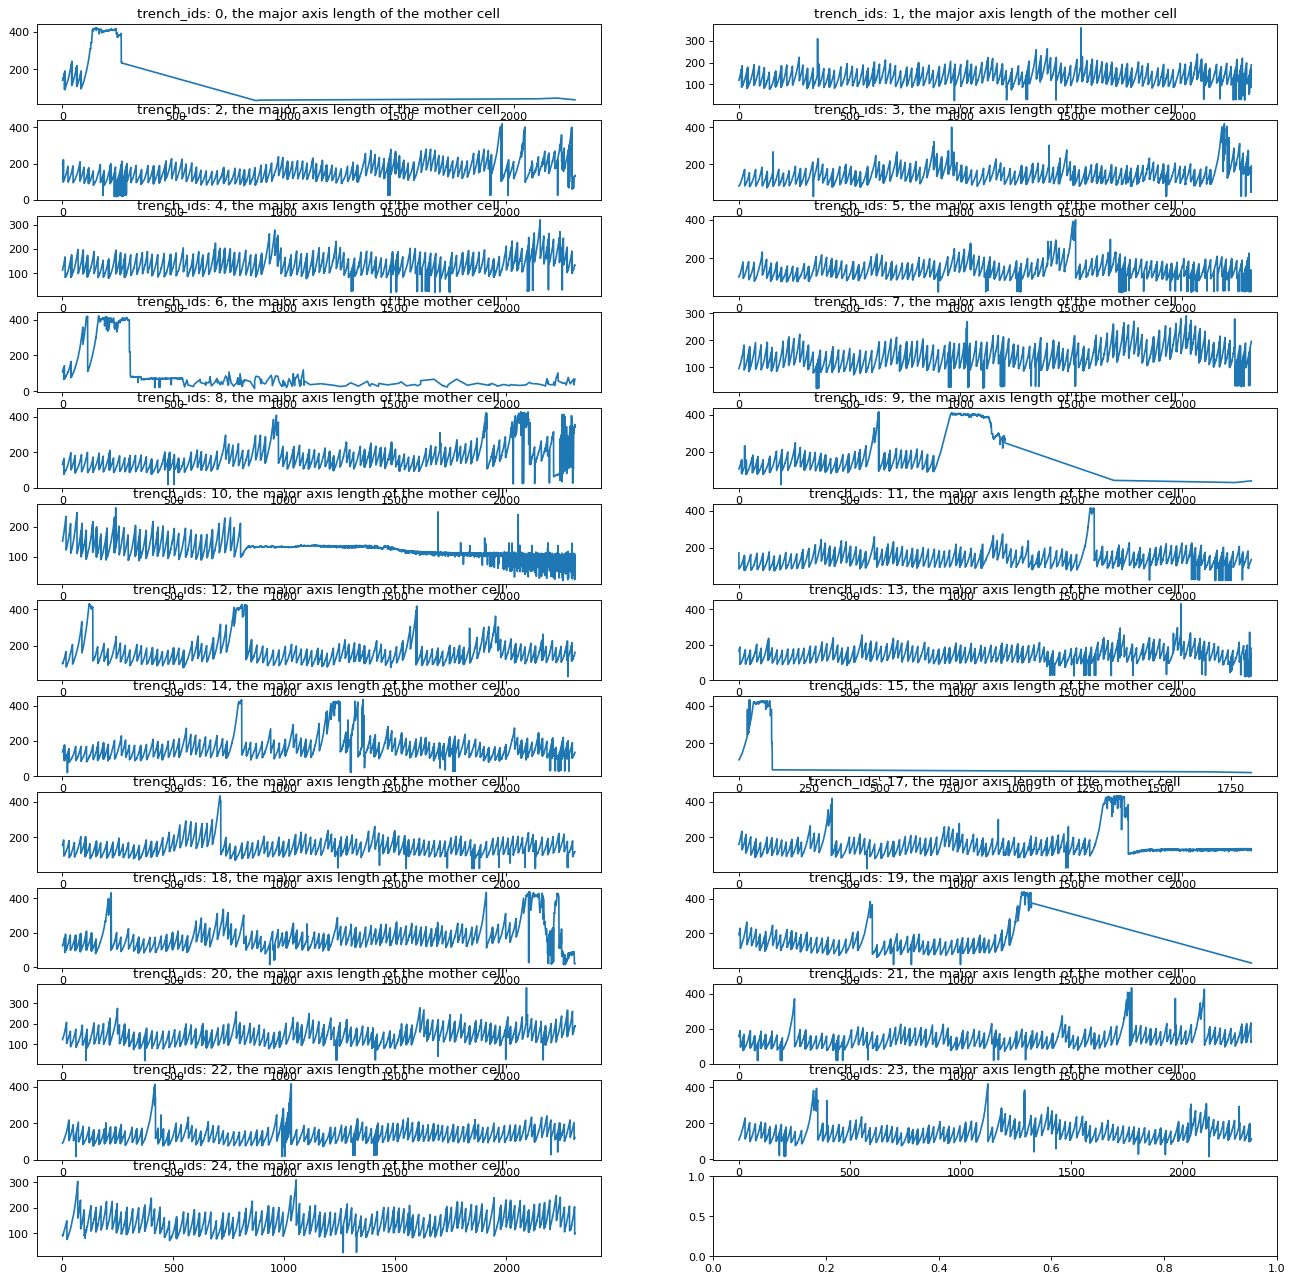

In [27]:
m = exp.get_mother_cell_growth(exp.trenches, plot=True)

In [30]:
props = ["trench_id", "time_(mins)", "label", "major_axis_length"]
mother_df = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                       (exp.df["trench_id"] != 0) &
                       (exp.df["trench_id"] != 6) &
                       (exp.df["trench_id"] != 9) &
                       (exp.df["trench_id"] != 10) &
                       (exp.df["trench_id"] != 15) &
                       # (exp.df["trench_id"] != 14) &
                       # (exp.df["trench_id"] != 15) &
                       (exp.df["trench_id"] != 19), props].copy()
mother_df.reset_index(drop=True, inplace=True)
display(mother_df.head(6))
trenches_l = mother_df.loc[:, "trench_id"]
trenches_l = sorted(list(set(trenches_l)))
for tr in tqdm(trenches_l):
    mother_cell = mother_df.loc[(mother_df["trench_id"] == tr), 
                              ["major_axis_length"]]
    # print(len(mother_cell))
    growth_r = np.median([np.log(mother_cell["major_axis_length"].iloc[i+1])
                        - np.log(mother_cell["major_axis_length"].iloc[i]) for i in range(1000)])
    # print(growth_r)
    for i in range(len(mother_cell) - 5):
        l1 = mother_cell["major_axis_length"].iloc[i]
        l2 = mother_cell["major_axis_length"].iloc[i + 1]
        l3 = mother_cell["major_axis_length"].iloc[i + 2]
        l4 = mother_cell["major_axis_length"].iloc[i + 3]
        l5 = mother_cell["major_axis_length"].iloc[i + 4]
        l6 = mother_cell["major_axis_length"].iloc[i + 5]
        dlog1 = np.log(l2) - np.log(l1)
        dlog2 = np.log(l3) - np.log(l2)
        dlog3 = np.log(l4) - np.log(l3)
        dlog4 = np.log(l5) - np.log(l4)
        dlog5 = np.log(l6) - np.log(l5)
        if dlog1 < - growth_r:
            if (dlog2 > 15 * growth_r) or (dlog3 > 15 * growth_r) or (dlog4 > 15 * growth_r) or (dlog5 > 15 * growth_r):
                # print(l2)
                # print(mother_df.loc[(mother_df["trench_id"] == tr), 
                #               ["major_axis_length"]].iloc[i + 1])
                # mother_df.loc[(mother_df["trench_id"] == tr), "major_axis_length"].iat[i + 1] = np.exp(growth_r) * l1
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
                # print(np.exp(growth_r) * l1)
                # print(mother_cell["major_axis_length"].iloc[i + 1])
                # print(mother_df.loc[(mother_df["trench_id"] == tr), 
                #               ["major_axis_length"]].iloc[i + 1])
                # print('correct false div')
            elif (dlog1 < - np.log(4)) and (l2 < 0.3 * np.median(mother_cell["major_axis_length"])):
                # print(np.median(mother_cell["major_axis_length"]))
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
        elif dlog1 > 5 * growth_r:
            mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
            # print('correct joining')
    mother_df.loc[(mother_df["trench_id"] == tr), ["major_axis_length"]] = mother_cell
    # if tr == 0:
    #     mother_df.loc[(mother_df["trench_id"] == tr), 
    #                           ["major_axis_length"]].plot(figsize=(100, 10))
    #     plt.show()
    #     break

mother_df.to_csv("/home/rl627/SSD1/SB8_30s_230224/short/mother/xy21_mother_length_corrected.csv")

trench_id  time_(mins)  label  major_axis_length
0          1          0.5      1         118.824654
1          1          1.0      1         119.787209
2          1          1.5      1         120.466423
3          1          2.0      1         122.446831
4          1          2.5      1         124.770157
5          1          3.0      1         126.801201

100%|███████████████████████████████████████████| 19/19 [00:02<00:00,  8.71it/s]


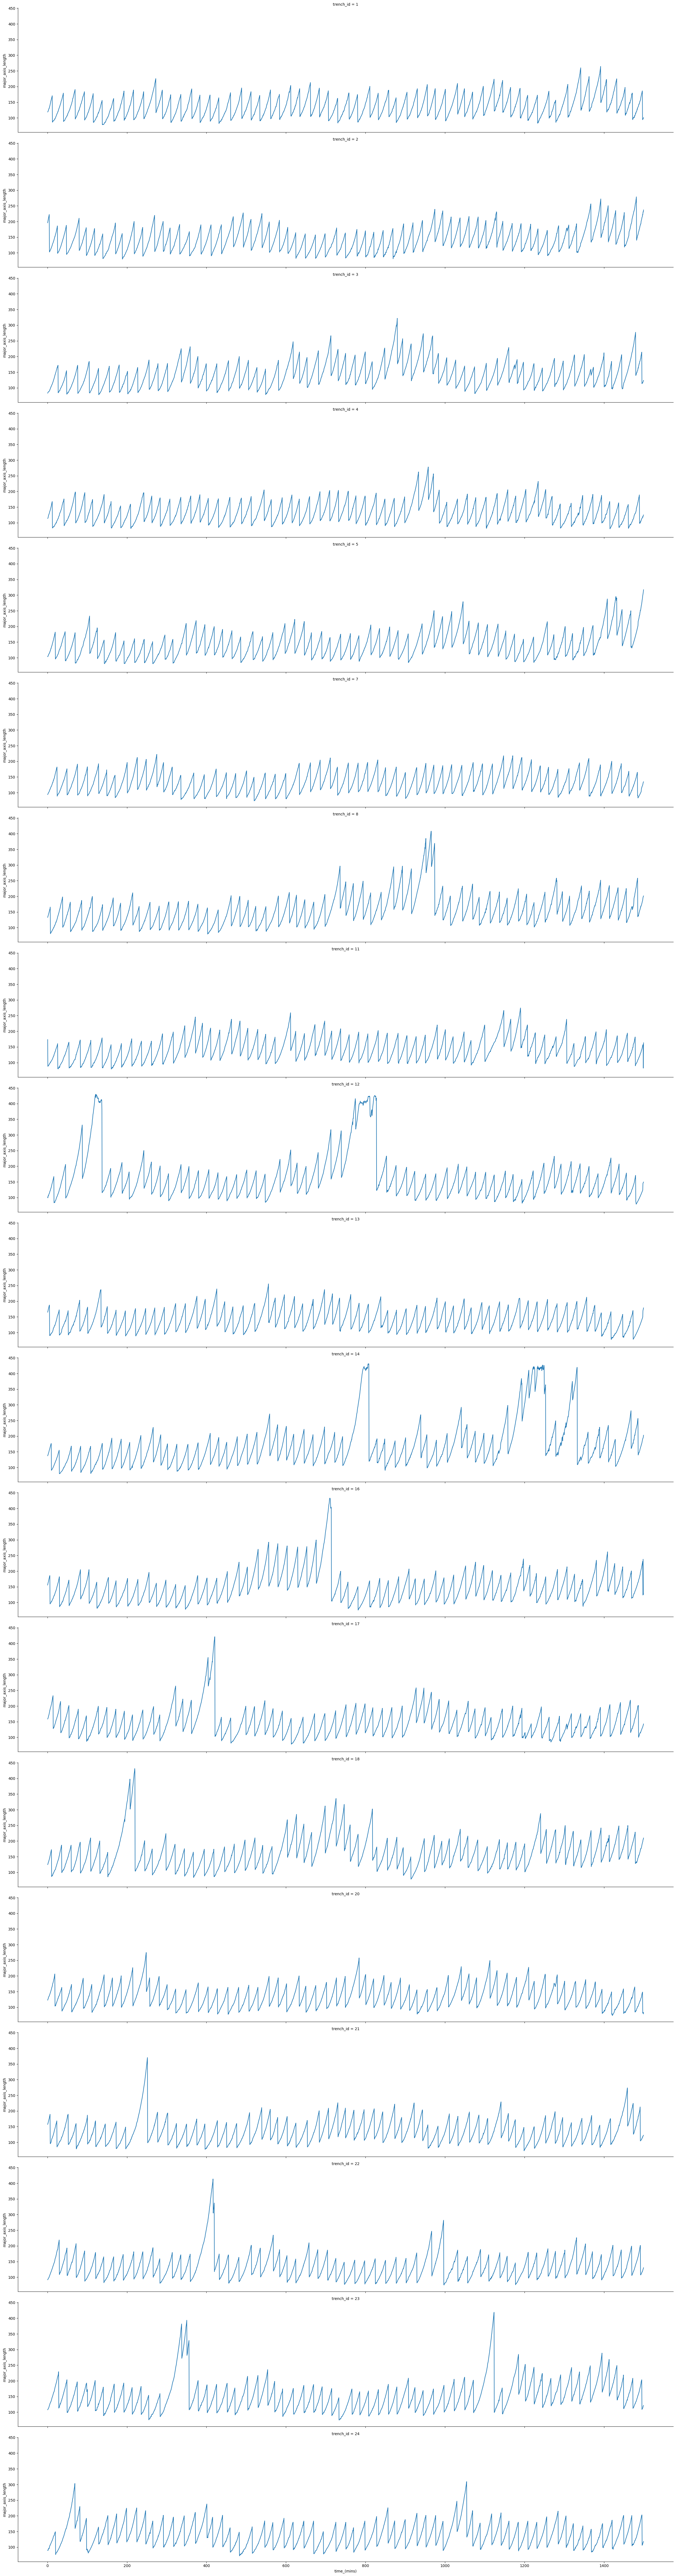

In [29]:
sns.relplot(data = mother_df, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)

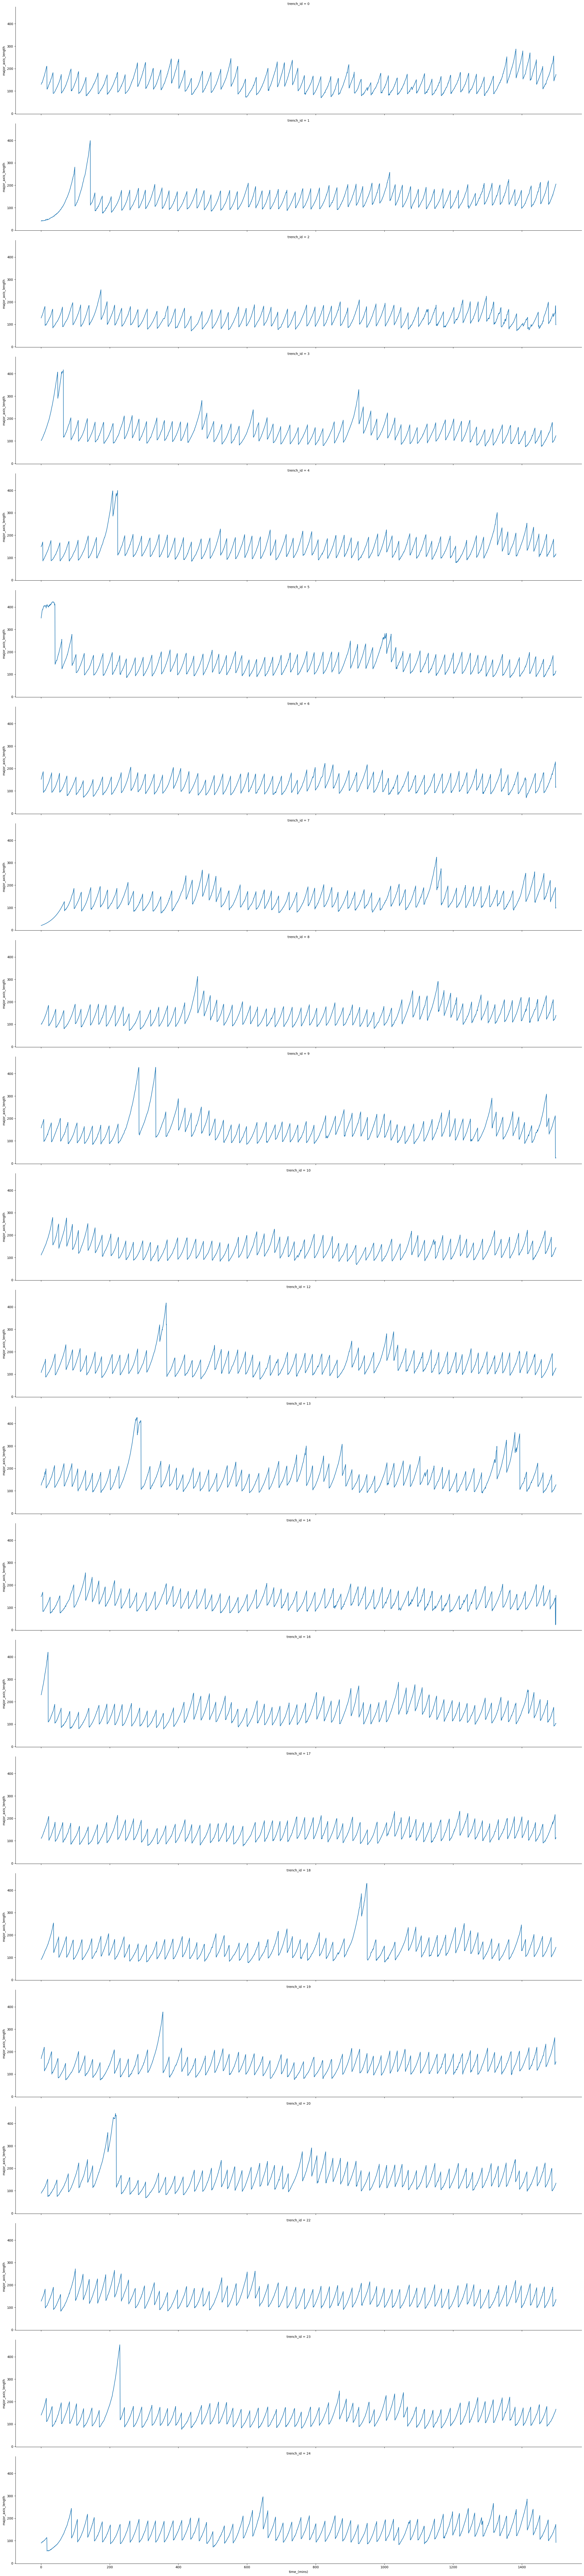

In [9]:
xy15 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy15_mother_length_corrected.csv')
xy20 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy20_mother_length_corrected.csv')
xy21 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy21_mother_length_corrected.csv')
xy22 = pd.read_csv('/home/rl627/SSD1/SB8_30s_230224/short/mother/xy22_mother_length_corrected.csv')
sns.relplot(data = xy22, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)
# sns.set(rc={'figure.figsize':(200, 10)})

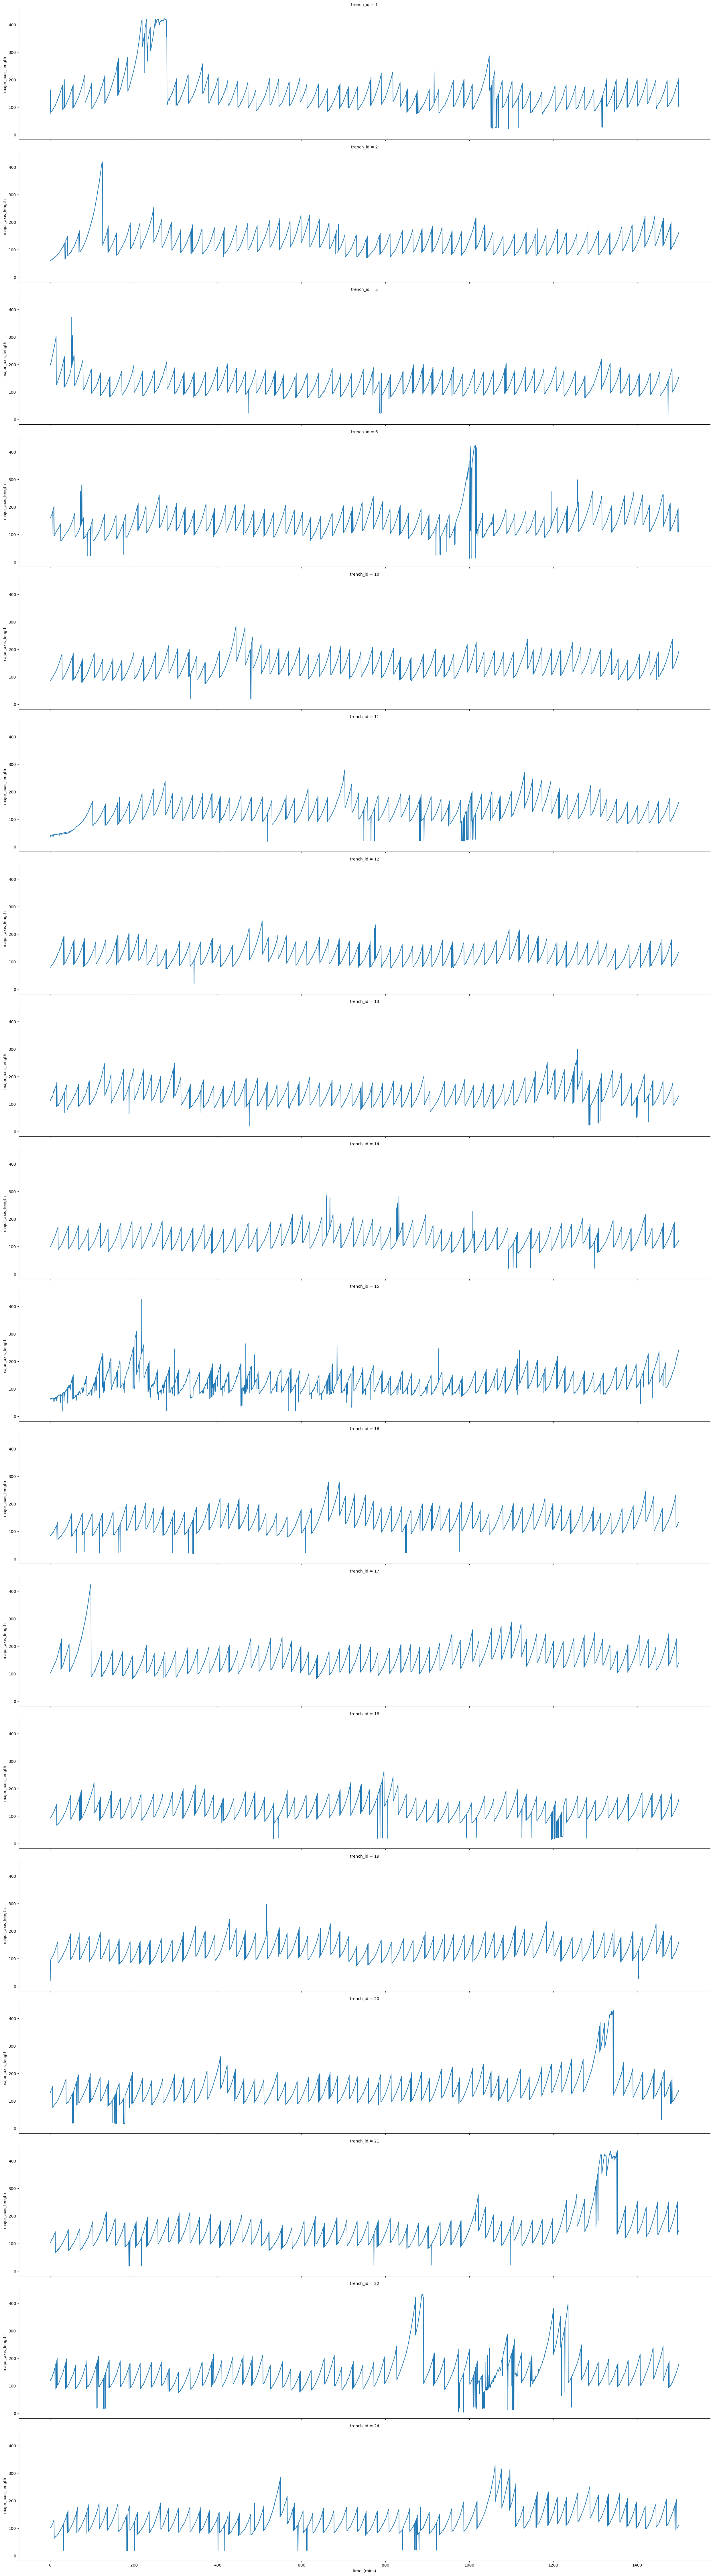

In [35]:
mother_df2 = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                       (exp.df["trench_id"] != 0) &
                       (exp.df["trench_id"] != 3) &
                       (exp.df["trench_id"] != 4) &
                       (exp.df["trench_id"] != 7) &
                       (exp.df["trench_id"] != 8) &
                       (exp.df["trench_id"] != 23) &
                       (exp.df["trench_id"] != 9), props].copy()
sns.relplot(data = mother_df2, x = "time_(mins)", y = "major_axis_length", kind = "line", 
            col = "trench_id", col_wrap = 1, aspect = 5)

100%|███████████████████████████████████████████| 22/22 [00:02<00:00, 10.79it/s]


0.04609175870858114


100%|███████████████████████████████████████████| 22/22 [00:01<00:00, 21.70it/s]


0.0331490034030141


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 33.12it/s]


0.02208835341365462


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 44.25it/s]


0.017730928588837437


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 53.88it/s]


0.015329469188529591


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 64.92it/s]


0.00998900293255132


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 75.78it/s]


0.010374331550802139


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 86.51it/s]


0.01078167115902965


100%|███████████████████████████████████████████| 22/22 [00:00<00:00, 96.77it/s]


0.008264462809917356


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 106.55it/s]


0.008292383292383292


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 117.18it/s]


0.006252112200067591


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 126.88it/s]


0.007021433850702144


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 135.05it/s]


0.006407689227072487


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 144.73it/s]


0.004093063334769496


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 154.60it/s]


0.0027829313543599257


100%|██████████████████████████████████████████| 22/22 [00:00<00:00, 159.81it/s]


0.0009881422924901185


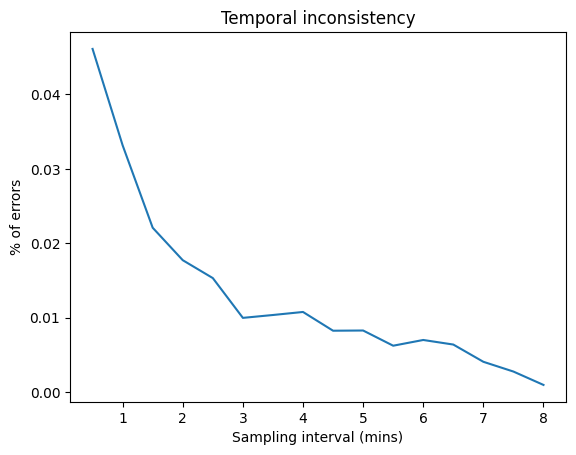

In [89]:
hysteresis = []
for step in range(1, 17):
    props = ["trench_id", "time_(mins)", "label", "major_axis_length"]
    mother_df = exp.df.loc[(exp.df["label"] == 1) & (exp.df["time_(mins)"] < 1500) & 
                           (exp.df["trench_id"] != 11) &
                           (exp.df["trench_id"] != 21) &
                           (exp.df["trench_id"] != 15) &
                           (exp.df["time_(mins)"] % (0.5 * step) == 0), props].copy()
    mother_df.reset_index(drop=True, inplace=True)
    # display(mother_df.head(6))
    trenches_l = mother_df.loc[:, "trench_id"]
    trenches_l = sorted(list(set(trenches_l)))
    count = 0
    total = 0
    for tr in tqdm(trenches_l):
        mother_cell = mother_df.loc[(mother_df["trench_id"] == tr), 
                                  ["major_axis_length"]]
        # print(len(mother_cell))
        growth_r = np.median([np.log(mother_cell["major_axis_length"].iloc[i+1])
                            - np.log(mother_cell["major_axis_length"].iloc[i]) for i in range(int(1500/step))])
        # print(growth_r)
        for i in range(len(mother_cell) - 3):
            total += 1
            l1 = mother_cell["major_axis_length"].iloc[i]
            l2 = mother_cell["major_axis_length"].iloc[i + 1]
            l3 = mother_cell["major_axis_length"].iloc[i + 2]
            l4 = mother_cell["major_axis_length"].iloc[i + 3]
            dlog1 = np.log(l2) - np.log(l1)
            dlog2 = np.log(l3) - np.log(l2)
            dlog3 = np.log(l4) - np.log(l3)
            if dlog1 < - growth_r:
                if dlog2 > 10 * growth_r or dlog3 > 10 * growth_r:

                    count += 1
                    mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1

            elif dlog1 > 10 * growth_r:
                count += 1
                mother_cell["major_axis_length"].iloc[i + 1] = np.exp(growth_r) * l1
                # print('correct joining')
        mother_df.loc[(mother_df["trench_id"] == tr), ["major_axis_length"]] = mother_cell

    count = count / total
    print(count)
    
    hysteresis.append(count)
plt.title("Temporal inconsistency")
plt.plot(0.5 * np.arange(1, 17), hysteresis)
plt.xlabel("Sampling interval (mins)")
plt.ylabel("% of errors")
plt.show()